# BMI Prediction From Human Photograph

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
!pip install git+git://github.com/stared/livelossplot.git

!git clone https://github.com/PeikeLi/Self-Correction-Human-Parsing
%cd /content/Self-Correction-Human-Parsing
!mkdir checkpoints
!mkdir inputs
!mkdir outputs
%cd /content

  Cloning git://github.com/stared/livelossplot.git to /tmp/pip-req-build-d2_buh0z
  Running command git clone --filter=blob:none --quiet git://github.com/stared/livelossplot.git /tmp/pip-req-build-d2_buh0z
  fatal: unable to connect to github.com:
  github.com[0: 20.205.243.166]: errno=Connection timed out

  error: subprocess-exited-with-error
  
  × git clone --filter=blob:none --quiet git://github.com/stared/livelossplot.git /tmp/pip-req-build-d2_buh0z did not run successfully.
  │ exit code: 128
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: subprocess-exited-with-error

× git clone --filter=blob:none --quiet git://github.com/stared/livelossplot.git /tmp/pip-req-build-d2_buh0z did not run successfully.
│ exit code: 128
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.
Cloning into 'Self-Correction-Human-Parsing'...
remote: Enumerating objects: 

In [1]:
! pip install livelossplot

In [2]:
import cv2
import time
import gdown
import numpy
import pandas

from pathlib import Path
from keras import backend as K
from livelossplot import PlotLossesKeras
from sklearn.model_selection import KFold

import keras
from keras import layers
from keras.models import Sequential
from keras.preprocessing import image

import matplotlib.pyplot as plt
%matplotlib inline

input_shape = (224, 224, 3)

# Dataset
The dataset consists of images sourced from multiple sources.
#### Sources
*   The Photographic Height-Weight Chart (www.height-weight-chart.com/heightweight.htm)
*   Celebrity Body Image based on the paper: Show me your face and I will tell you your height, weight and BMI. Data downloaded manually from google images. (https://hal.inria.fr/hal-01799574/document)
*   Face-to-height-weight-BMI-estimation (https://github.com/abhaymise/Face-to-height-weight-BMI-estimation-)

Due to the lack of data availability, the three different sources from existing projects conducted similar to this project was fetched and used. Along with this we also have the Height in Feet and Inches, Weight in Pounds and the BMI calculated based on this (The Imperial System was used).

The formula to calculate BMI is as follows:
\begin{equation}
BMI = \frac{Pound * 703}{(Foot * 12 + Inch)^2}
\end{equation}

The dataset consists a total of 2,272 Images where these images will be split into training and testing and used for the purpose of model training and validation.

## Load Data
Before beginning the process, the dataset needs to be loaded.
The CSV files contain the Image File Path, the weight (in pounds), the height in foot and inches. The BMI can be derived using the previously mentioned equation.
The data is present in two different files due to the nature of how the data was gathered.

*   **celeb_datasets.csv** (Source: Abhaymise and custom collection)
*   **height-weight-chart_dataset.csv** (Source: Photographic Height Weight Chart)


In [3]:
# Load data into dataframe
df_hwcd = pandas.read_csv("height-weight-chart_dataset.csv")
df_celeb = pandas.read_csv("celeb_datasets.csv")

In [4]:
# Merge the two dataframes
df = df_hwcd.append(df_celeb, ignore_index=True)

<ipython-input-4-a32f115a5617>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df_hwcd.append(df_celeb, ignore_index=True)


Calculate the BMI using the Weight and Heigh (Foot and Inches) and add it back to the dataframe.

In [5]:
bmi = df["weight"] * 703 / (df["foot"] * 12 + df["inch"]) ** 2

BMI (Mean): 26.58938050842102
BMI (Standard Deviation): 6.666706916267456


,image_filename,weight,foot,inch,bmi
0,410-090-0.png,90,4,10,18.807967
1,410-090-1.png,90,4,10,18.807967
2,410-090-2.png,90,4,10,18.807967
3,410-090-3.png,90,4,10,18.807967
4,410-090-4.png,90,4,10,18.807967
...,...,...,...,...,...
2267,colinfarrell1.jpg,176,5,10,25.250612
2268,colinfarrell2.jpg,176,5,10,25.250612
2269,colinfarrell3.jpg,176,5,10,25.250612
2270,colinfarrell4.jpg,176,5,10,25.250612


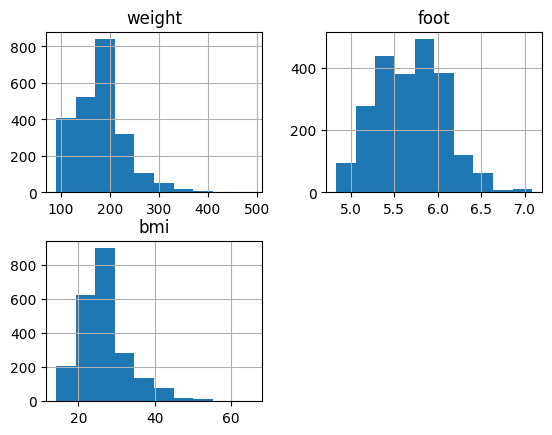

In [6]:
# Visualize the data as a Histogram to understtand the data distribution
# Convert Feet/Foot and Inches to Feet
foot = df["foot"] + df["inch"] / 12
df_display = df.drop(columns=["foot", "inch"])
df_display = df_display.assign(foot=foot, bmi=bmi)
df_display.hist()

print(f"BMI (Mean): {bmi.mean()}")
print(f"BMI (Standard Deviation): {bmi.std()}")
df.assign(bmi=bmi)

## Preprocessing Data
It is important to preprocess the data before using it to train the model and also before the data is fed to the model to get predictions out of in the future.<br>
We need a masking process to remove the background from the image and only extract the person from the image. The background can add unnecessary noise when training the model and provide incorrect results. Therefore, as part of the preprocessing we have to extract person out of image.


An existing solution was used in the current phase of the project: https://github.com/GoGoDuck912/Self-Correction-Human-Parsing
Self Correction for Human Parsing. This component produces the following output given an image of a person:

<table>
  <tr>
    <td>
      Original Image:<br>
      <img src="https://raw.githubusercontent.com/GoGoDuck912/Self-Correction-Human-Parsing/master/demo/demo.jpg" width="200">
    </td>
    <td>
      Preprocessed Image (LIP Parsing):<br>
      <img src="https://raw.githubusercontent.com/GoGoDuck912/Self-Correction-Human-Parsing/master/demo/demo_lip.png" width="200">
    </td>
    <td>
      Preprocessed Image (Pascal Person Parsing):<br>
      <img src="https://raw.githubusercontent.com/GoGoDuck912/Self-Correction-Human-Parsing/master/demo/demo_pascal.png" width="200">
    </td>
    <td>
      Preprocessed Image (ATR Parsing):<br>
      <img src="https://raw.githubusercontent.com/GoGoDuck912/Self-Correction-Human-Parsing/master/demo/demo_atr.png" width="200">
    </td>
  </tr>
</table>

As you can see from the above result, the preprocessed image contains a mostly accurate human parsed representation. The process provides 3 types of parsing as evident from the above. Out of the three LIP and PascalPersonParsing seems to provide the best results as it identifies only the person while ATR seems to be picking a portion of the background.

After the above step, the image will be converted into a mask. This is achieved by converting all the colored pixel to white leaving the rest of the pixels as black.
\begin{equation}
IF (Pixel_Color) > 0 THEN Pixel_Color = 1
\end{equation}
<br>
The generated mask can then be applied on the image which will generate only the person on the image while the background being black.

Example:

<table>
  <tr>
    <td>
      Filter Image:<br>
      <img src="https://drive.google.com/uc?export=view&id=18rjY14s3a_i9tYWXGR-FOLu0PJ2LpkvG" width="200">
    </td>
    <td>
      Labeled Image:<br>
      <img src="https://drive.google.com/uc?export=view&id=1Bqf6gtkBdL8xhsP8hEXcMDeHMVyiu_k4" width="200" height="273">
    </td>
  </tr>
</table>

As evident from the above, applying the mask on the image will result in generating an image where the background is darkened and the white areas are made transparent in the original image resulting in the person being visible only. Further the images are also resized to 224 * 224. This is because of the model being used to train (and due to Transfer learning being used).

In [ ]:
RAW_DATASET = 'drive/MyDrive/NutritionML/BMI/raw_datasets/'
RAW_PREPROCESSED_DATASET = 'drive/MyDrive/NutritionML/BMI/raw_datasets_preprocessed/'
CELEB_DATASET = 'drive/MyDrive/NutritionML/BMI/celeb_datasets/'
CELEB_PREPROCESSED_DATASET = 'drive/MyDrive/NutritionML/BMI/celeb_datasets_preprocessed/'

def preprocess_df(x, y):
  x = x.reset_index()
  X = []
  Y = []
  for i in range(x.shape[0]):
    # Read image filename from file path
    image_filename = Path(x['image_filename'][i]).stem

    # Check if the file is present as part of raw data
    raw_filepath = f"{RAW_DATASET}{image_filename}.jpg"
    preprocessed_filepath = f"{RAW_PREPROCESSED_DATASET}{image_filename}.png"
    # If the File is not part of RAW and instead part of CELEB
    if not Path(raw_filepath).is_file():
      print(f"{image_filename} is not a file in raw")
      raw_filepath = f"{CELEB_DATASET}/{image_filename}.jpg"
      preprocessed_filepath = f"{CELEB_PREPROCESSED_DATASET}{image_filename}.png"

    # Given the file is valid, preprocess the images
    if Path(raw_filepath).is_file() and Path(preprocessed_filepath).is_file():
      # Resize the Image and convert to array so that it can be used to apply the mask
      raw_img = image.load_img(raw_filepath, target_size=(600, 400))
      raw_img = image.img_to_array(raw_img)
      preprocessed_img = image.load_img(preprocessed_filepath, target_size=(600, 400))
      preprocessed_img = image.img_to_array(preprocessed_img)

      # Replace the colored pixels in the image with white color
      preprocessed_img[preprocessed_img[:,:,0] > 0] = 1
      preprocessed_img[preprocessed_img[:,:,1] > 0] = 1
      preprocessed_img[preprocessed_img[:,:,2] > 0] = 1

      # Store the target images and the label
      X.append(cv2.resize(raw_img * preprocessed_img, (input_shape[0], input_shape[1])))
      Y.append(y.iloc[i])

  X = numpy.array(X)
  Y = numpy.array(Y)
  return X, Y

start = time.time()
X, Y = preprocess_df(df, bmi)
end = time.time()
print(f"{end - start:.2f} seconds process time")

410-170-0 is not a file in raw
411-100-1 is not a file in raw
411-100-2 is not a file in raw
500-140-4 is not a file in raw
500-220-1 is not a file in raw
501-100-1 is not a file in raw
501-110-1 is not a file in raw
501-110-10 is not a file in raw
501-110-13 is not a file in raw
501-120-2 is not a file in raw
501-120-5 is not a file in raw
501-150-2 is not a file in raw
501-160-1 is not a file in raw
501-190-2 is not a file in raw
502-110-1 is not a file in raw
502-110-15 is not a file in raw
502-130-8 is not a file in raw
502-200-1 is not a file in raw
502-200-3 is not a file in raw
504-090-0 is not a file in raw
504-090-1 is not a file in raw
504-110-2 is not a file in raw
504-110-3 is not a file in raw
504-140-0 is not a file in raw
504-140-1 is not a file in raw
504-170-3 is not a file in raw
504-170-4 is not a file in raw
504-220-2 is not a file in raw
505-100-2 is not a file in raw
505-100-3 is not a file in raw
505-120-9 is not a file in raw
505-130-4 is not a file in raw
505-1

## Data Augmentation
As evident earlier, the total number of images in the dataset is quite limited. Therefore it is important to expand the dataset by applying some data augmentation techniques. This will allow to artificially increase the size of the dataset.

To do so we use traditional augmentation techniques such as Rotating, Shifting Image and Flipping images horizontally. These augmentation can generate new images without drastically affecting the outcome of the network (But is experimental).

Augmentation is only applied to train dataset and not the test data since training data is where augmentation is needed. When testing we need to test with real images.

In [ ]:
train_datagen = image.ImageDataGenerator(
  samplewise_center=True,
  rotation_range=2,
  width_shift_range=0.02,
  horizontal_flip=True
)

In [ ]:
test_datagen = image.ImageDataGenerator(
  samplewise_center=True,
)

## Model Building

The model building process involves the use of a technique known as Transfer Learning. This process involves taking up an existing pretrained model (initialized with weights already learned from a more generalized dataset - imagenet).
The CNN model is used to extract features and the extracted features are then fed into a fully connected layer which further passes the data to a output layer which produces the final result. This will then predict the BMI based on the previously extracted features.

###FCN
*   CNN Model as Input with Input Shape (224,224,3)
*   A fully Connected layer with 256 Neurons
*   Activiation Function: ReLu
*   Output Layer - Linear Activation Function - 1 neuron

###CNN Architectures explored
*   VGG16
*   InceptionV3
*   MobileNet

Measure model performance using coeff determination and Mean Absolute Error. The Loss used as part of this process is known as Huber.

The Huber loss function can be used to balance between the Mean Absolute Error, or MAE, and the Mean Squared Error, MSE. It is therefore a good loss function for when you have varied data or only a few outliers.

Change Learning Rate over training process based on the lr_scheduler function. The Learning rate is adjusted using a formula after every epoch and this allows the model to improve learning as it goes through the training process.

#### Model Configuration

* Optimizer: The stochastic gradient descent (SGD) algorithm.
* Learning Rate: Start from 1e-5 and then we use the learning rate decay policy, which is implemented as follows:
\begin{equation}
LR = LR_{Base} (1 + \gamma * epoch)^{-power}
\end{equation}
where γ is 0.001 and power is 0.75. We use a momentum of 0.9
* Loss function: Huber function
* Metrics: Huber, Mean Absolute Error and R Squared

In [ ]:
def coeff_determination(y_true, y_pred):
  SS_res =  K.sum(K.square( y_true-y_pred ))
  SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
  return ( 1 - SS_res/(SS_tot + K.epsilon()) )

def lr_scheduler(epoch, lr):
  return 1e-5 * (1 + 0.001 * epoch) ** (-0.75)

### Define the Models

#### VGG16

In [12]:
# VGG16
model_VGG16 = keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=input_shape
)
model_VGG16.trainable = False

In [19]:
model_VGG16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

K Fold Cross Validation is used as part of the training process where the data is split into K (in this case 5) and for each iteration 4 folds are used for training and 1 fold is used for testing. Based on the final

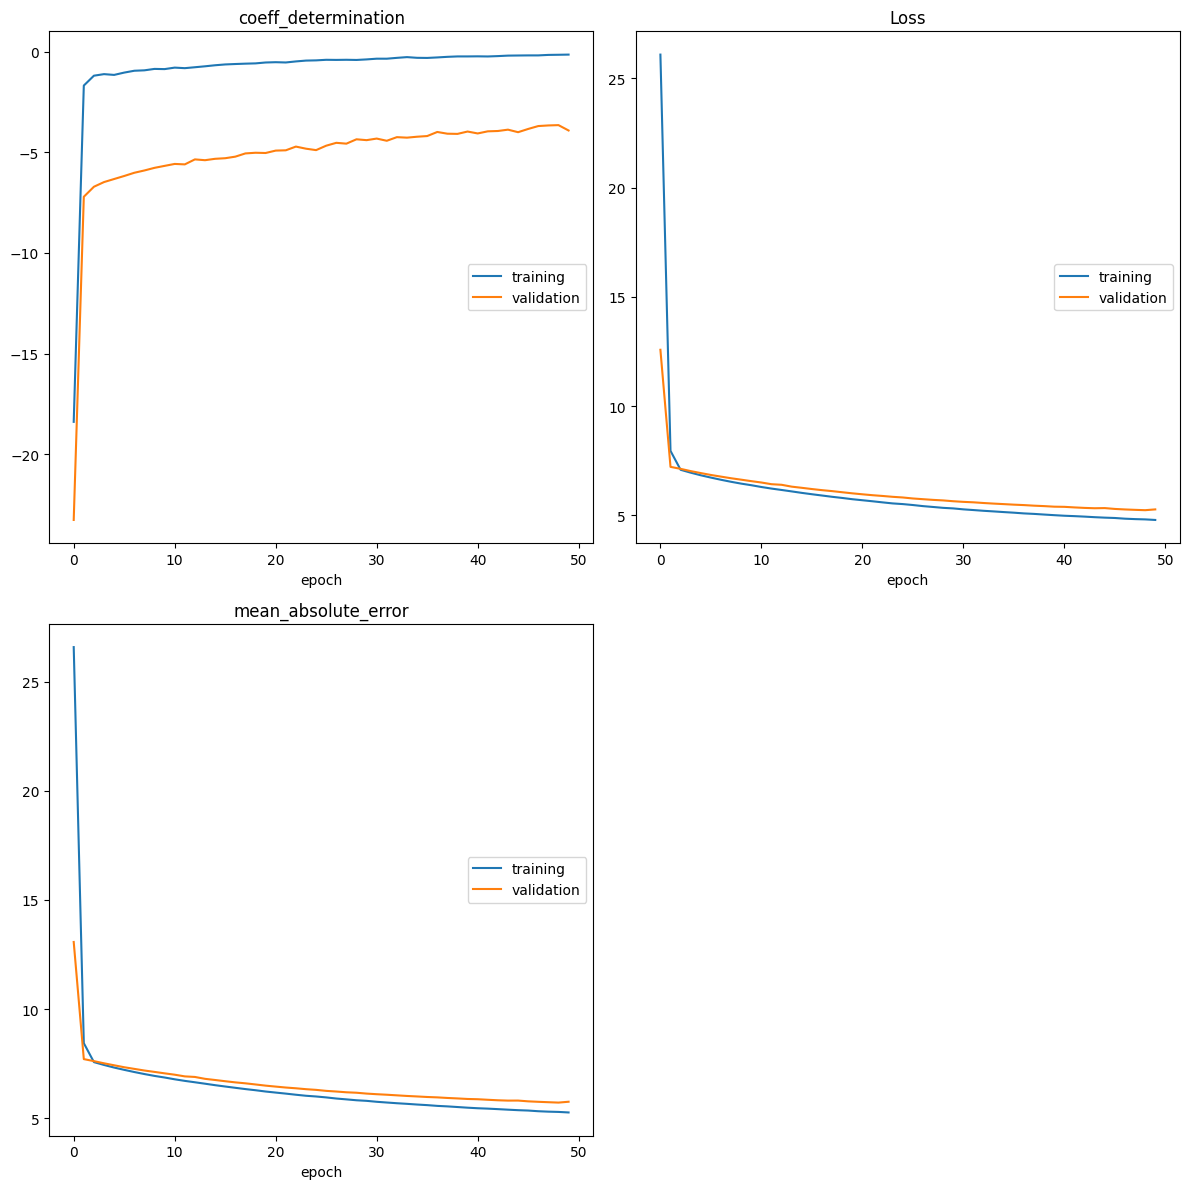

coeff_determination
	training         	 (min:  -18.382, max:   -0.152, cur:   -0.152)
	validation       	 (min:  -23.252, max:   -3.653, cur:   -3.919)
Loss
	training         	 (min:    4.786, max:   26.093, cur:    4.786)
	validation       	 (min:    5.233, max:   12.578, cur:    5.269)
mean_absolute_error
	training         	 (min:    5.257, max:   26.592, cur:    5.257)
	validation       	 (min:    5.709, max:   13.073, cur:    5.748)
46/46 - 8s - loss: 4.7860 - mean_absolute_error: 5.2573 - coeff_determination: -1.5249e-01 - val_loss: 5.2692 - val_mean_absolute_error: 5.7483 - val_coeff_determination: -3.9191e+00 - lr: 9.6476e-06 - 8s/epoch - 168ms/step


In [20]:
histories_VGG16 = []
k = 0
kf = KFold(n_splits=5, shuffle=True)
for train_index, test_index in kf.split(X):
  inputs = keras.Input(shape=(224, 224, 3))
  # We make sure that the base_model is running in inference mode here,
  # by passing `training=False`. This is important for fine-tuning, as you will
  # learn in a few paragraphs.
  x = model_VGG16(inputs, training=False)
  # Convert features of shape `base_model.output_shape[1:]` to vectors
  x = keras.layers.GlobalAveragePooling2D()(x)
  x = keras.layers.Dense(256, activation='relu')(x)
  # A Dense classifier with a single unit (binary classification)
  outputs = keras.layers.Dense(1, activation='linear')(x)
  model_VGG16_FCN = keras.Model(inputs, outputs)

  model_VGG16_FCN.compile(optimizer=keras.optimizers.SGD(
      learning_rate=1e-5,
      momentum=0.9
      ), loss=keras.losses.Huber(), metrics=["mean_absolute_error", coeff_determination])

  X_train, y_train, X_test, y_test = X[train_index], Y[train_index], X[test_index], Y[test_index]
  k += 1

  history = model_VGG16_FCN.fit(X_train, y_train, epochs=50,
    validation_data=(X_test, y_test),
    verbose=2,
    callbacks=[
          PlotLossesKeras(),
          keras.callbacks.LearningRateScheduler(lr_scheduler),
    ]
  )

  histories_VGG16.append(history)

In [21]:
model_VGG16_FCN.evaluate(X_test, y_test)

12/12 [==============================] - 1s 118ms/step - loss: 5.2692 - mean_absolute_error: 5.7483 - coeff_determination: -3.9191


[5.2691802978515625, 5.748293876647949, -3.919076919555664]

#### InceptionV3

In [23]:
# InceptionV3
model_InceptionV3 = keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=input_shape,
    pooling="avg"
)
model_InceptionV3.trainable = False

In [24]:
model_InceptionV3.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

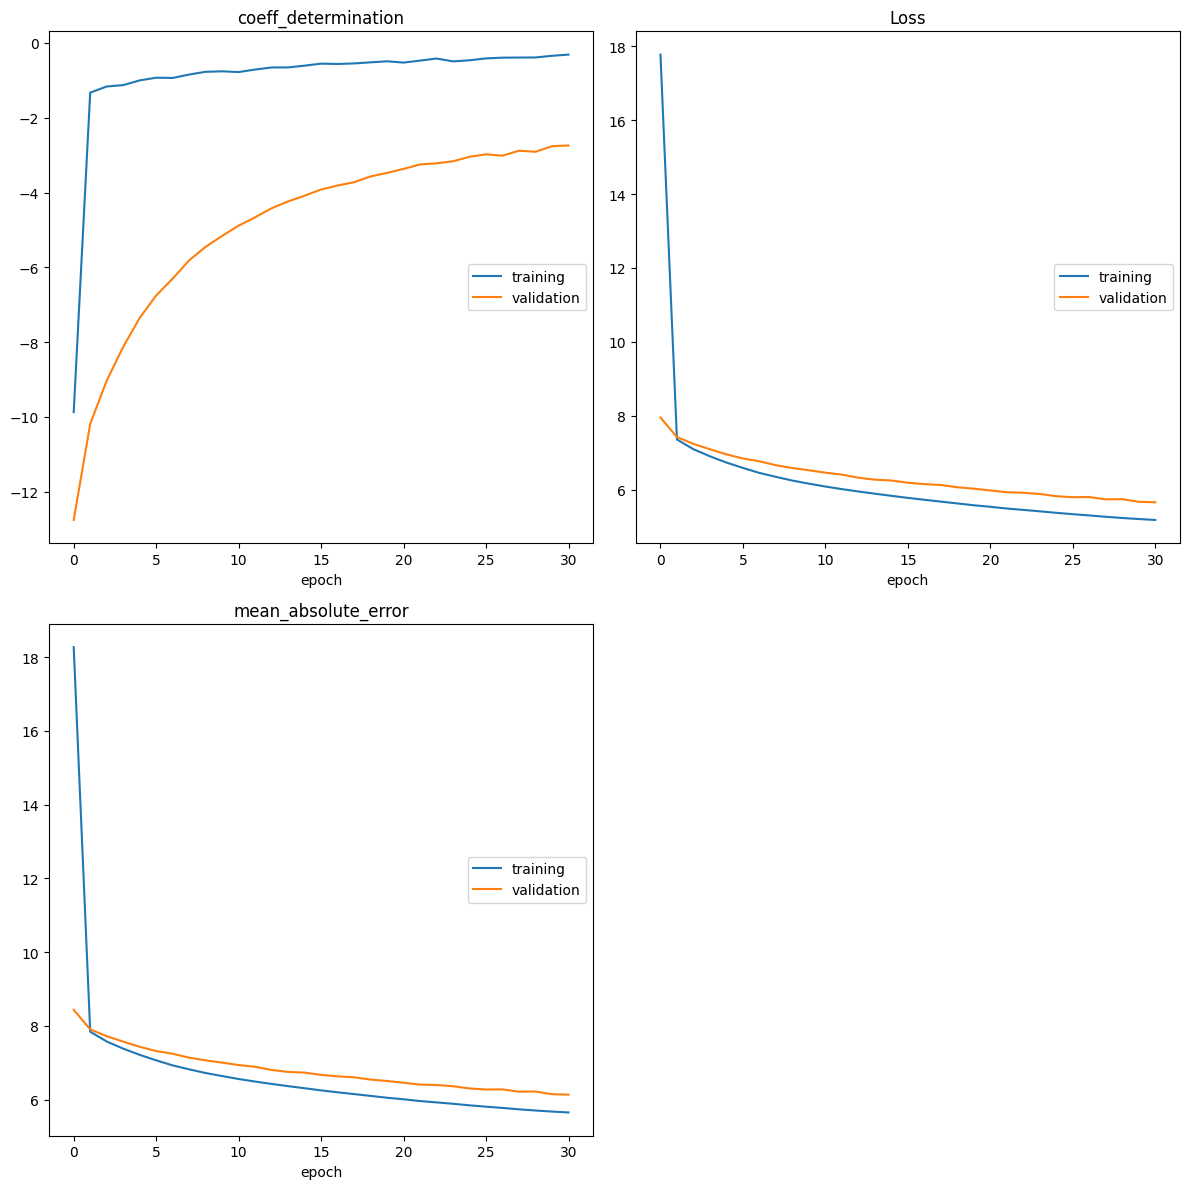

coeff_determination
	training         	 (min:   -9.870, max:   -0.312, cur:   -0.312)
	validation       	 (min:  -12.754, max:   -2.742, cur:   -2.742)
Loss
	training         	 (min:    5.178, max:   17.776, cur:    5.178)
	validation       	 (min:    5.657, max:    7.950, cur:    5.657)
mean_absolute_error
	training         	 (min:    5.654, max:   18.271, cur:    5.654)
	validation       	 (min:    6.138, max:    8.437, cur:    6.138)
46/46 - 9s - loss: 5.1777 - mean_absolute_error: 5.6543 - coeff_determination: -3.1157e-01 - val_loss: 5.6568 - val_mean_absolute_error: 6.1377 - val_coeff_determination: -2.7418e+00 - lr: 9.7807e-06 - 9s/epoch - 200ms/step
Epoch 32/50


In [ ]:
histories_InceptionV3 = []
k = 0
kf = KFold(n_splits=5, shuffle=True)
for train_index, test_index in kf.split(X):
  inputs = keras.Input(shape=(224, 224, 3))
  # We make sure that the base_model is running in inference mode here,
  # by passing `training=False`. This is important for fine-tuning, as you will
  # learn in a few paragraphs.
  x = model_InceptionV3(inputs, training=False)
  # Convert features of shape `base_model.output_shape[1:]` to vectors
  x = keras.layers.Flatten()(x)
  x = keras.layers.Dense(256, activation='relu')(x)
  # A Dense classifier with a single unit (binary classification)
  outputs = keras.layers.Dense(1, activation='linear')(x)
  model_InceptionV3_FCN = keras.Model(inputs, outputs)

  model_InceptionV3_FCN.compile(optimizer=keras.optimizers.SGD(
      learning_rate=1e-5,
      momentum=0.9
  ), loss=keras.losses.Huber(), metrics=["mean_absolute_error", coeff_determination])

  X_train, y_train, X_test, y_test = X[train_index], Y[train_index], X[test_index], Y[test_index]
  k += 1

  history = model_InceptionV3_FCN.fit(X_train, y_train, epochs=50,
    validation_data=(X_test, y_test),
    verbose=2,
    callbacks=[
          PlotLossesKeras(),
          keras.callbacks.LearningRateScheduler(lr_scheduler),
    ]
  )

  histories_InceptionV3.append(history)

In [ ]:
model_InceptionV3_FCN.evaluate(X_test, y_test)

#### MobileNet

In [17]:
# MobileNet
model_MobileNet = keras.applications.MobileNet(
    include_top=False,
    weights="imagenet",
    input_shape=input_shape,
    pooling="avg"
)
model_MobileNet.trainable = False

17225924/17225924 [==============================] - 2s 0us/step


In [18]:
model_MobileNet.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32

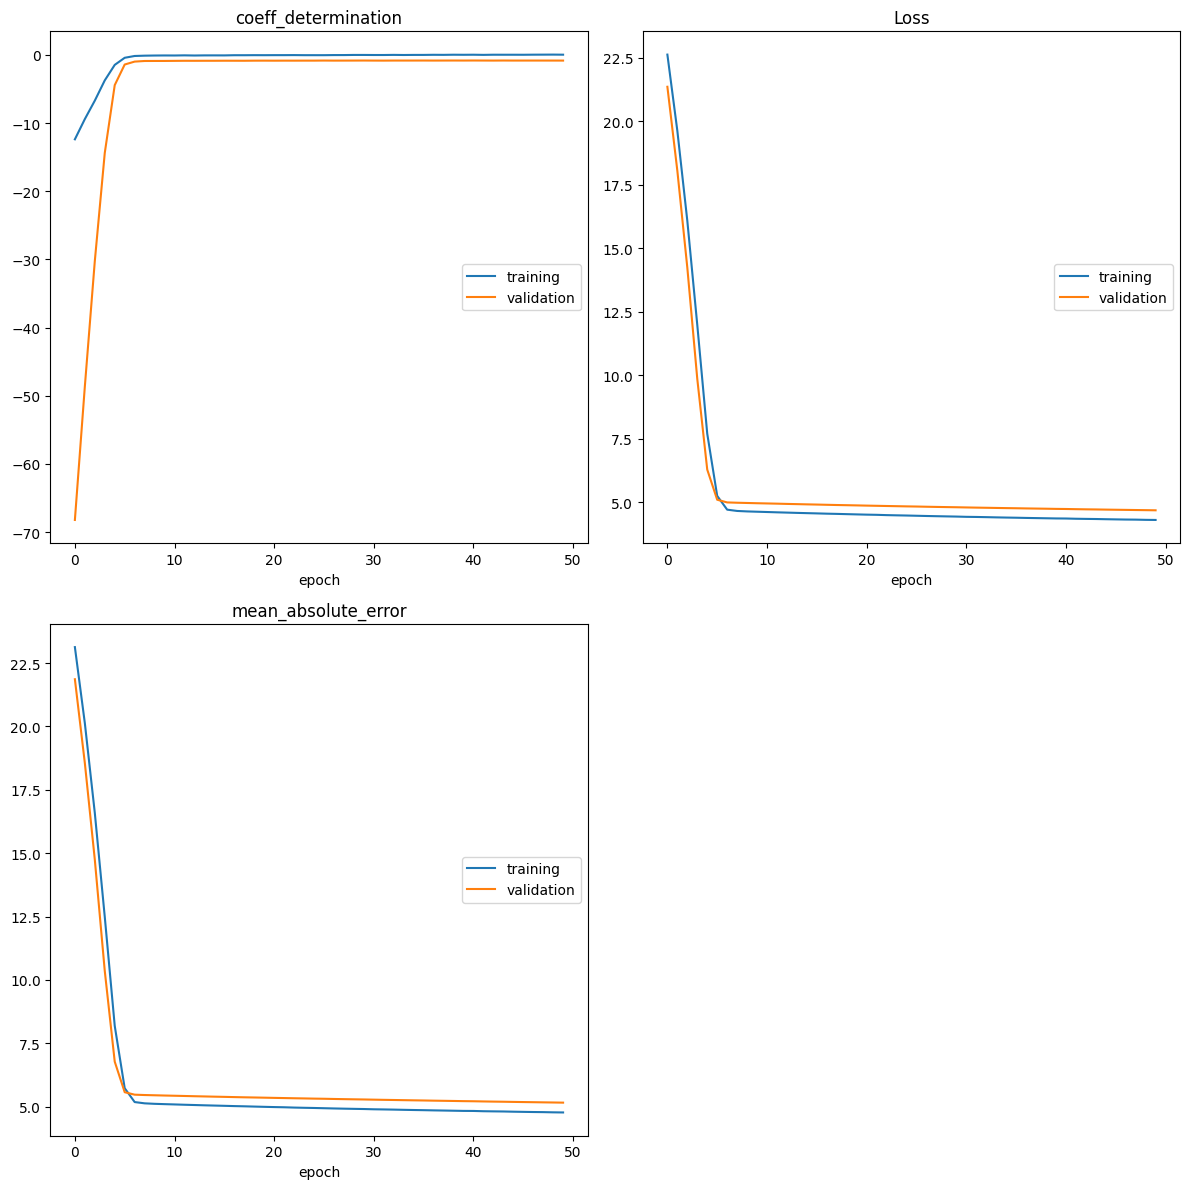

coeff_determination
	training         	 (min:  -12.387, max:    0.038, cur:    0.025)
	validation       	 (min:  -68.218, max:   -0.828, cur:   -0.840)
Loss
	training         	 (min:    4.304, max:   22.628, cur:    4.304)
	validation       	 (min:    4.684, max:   21.361, cur:    4.684)
mean_absolute_error
	training         	 (min:    4.772, max:   23.128, cur:    4.772)
	validation       	 (min:    5.159, max:   21.861, cur:    5.159)
46/46 - 3s - loss: 4.3036 - mean_absolute_error: 4.7720 - coeff_determination: 0.0253 - val_loss: 4.6837 - val_mean_absolute_error: 5.1591 - val_coeff_determination: -8.3956e-01 - lr: 9.6476e-06 - 3s/epoch - 70ms/step


In [21]:
histories_MobileNet = []
k = 0
kf = KFold(n_splits=5, shuffle=True)
for train_index, test_index in kf.split(X):
  inputs = keras.Input(shape=(224, 224, 3))
  # We make sure that the base_model is running in inference mode here,
  # by passing `training=False`. This is important for fine-tuning, as you will
  # learn in a few paragraphs.
  x = model_MobileNet(inputs, training=False)
  # Convert features of shape `base_model.output_shape[1:]` to vectors
  x = keras.layers.Flatten()(x)
  x = keras.layers.Dense(256, activation='relu')(x)
  # A Dense classifier with a single unit (binary classification)
  outputs = keras.layers.Dense(1, activation='linear')(x)
  model_MobileNet_FCN = keras.Model(inputs, outputs)

  model_MobileNet_FCN.compile(optimizer=keras.optimizers.SGD(
      learning_rate=1e-5,
      momentum=0.9
      ), loss=keras.losses.Huber(), metrics=["mean_absolute_error", coeff_determination])

  X_train, y_train, X_test, y_test = X[train_index], Y[train_index], X[test_index], Y[test_index]
  k += 1

  history = model_MobileNet_FCN.fit(X_train, y_train, epochs=50,
    validation_data=(X_test, y_test),
    verbose=2,
    callbacks=[
          PlotLossesKeras(),
          keras.callbacks.LearningRateScheduler(lr_scheduler),
    ]
  )

  histories_MobileNet.append(history)

In [22]:
model_MobileNet_FCN.evaluate(X_test, y_test)

12/12 [==============================] - 1s 45ms/step - loss: 4.6837 - mean_absolute_error: 5.1591 - coeff_determination: -0.8396


[4.683713436126709, 5.159061431884766, -0.8395611643791199]